Imports

In [0]:
import os,time
from pyspark import SparkContext
from pyspark.sql.functions import col, count, max as spark_max
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum, max as spark_max
import pyspark.sql.functions as F
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import DenseVector, SparseVector, VectorUDT
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors as OldVectors
from pyspark.mllib.linalg.distributed import RowMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Spark Load

In [0]:
spark = SparkSession.builder.appName("my_project_2").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sc = spark.sparkContext

# Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_demographic.parquet")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: string (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: integer (nullable = true)
 |-- net_worth: integer (nullable = true)
 |-- education_highest: integer (nullable = true)
 |-- gender_individual: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,education_highest,gender_individual
00000015,2,2,1,S,B,S,O,5,5,6,4,M
00000028,3,2,2,S,W,S,O,3,8,5,2,M
00000056,2,2,1,S,W,S,O,4,10,5,1,M
00000061,2,2,2,M,W,S,O,15,8,8,1,M
00000098,3,2,2,M,W,S,O,4,13,7,1,F
00000111,2,2,1,S,W,S,O,15,4,8,2,M
00000122,3,2,2,M,W,S,O,8,7,7,2,F
00000130,2,2,2,S,W,S,O,8,8,6,2,M
00000145,1,1,1,B,W,S,O,3,6,5,1,M
00000160,2,2,1,A,W,S,O,15,6,6,1,M


# Read Static Viewing Data

In [0]:
static_viewing_df = spark.read.parquet("/dbfs/mnt/coursedata2024/fwm-stb-data/Project2_static_viewing_data.parquet")
static_viewing_df.printSchema()
display(static_viewing_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: integer (nullable = true)
 |-- event_time: integer (nullable = true)
 |-- station_num: string (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: long (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
000000d8b042,20151101,500,31709,EP015686040014,1463331
000000fb0fe7,20151101,230000,11006,EP001151270249,1447701
0000010e4717,20151101,13000,49788,EP003267331348,1447541
0000015ce10e,20151101,153432,50001,EP013605340004,2880783
000004351a40,20151101,65207,59636,SP003189620000,2882159
000004d26feb,20151101,210550,14988,MV002161540000,405836
000005ac0b7c,20151101,194211,63322,EP015662900055,397950
000013fb3e40,20151101,123000,16374,SH006818540000,399721
00001602e18b,20151101,64445,18090,SP003189620000,400046
000002c427cf,20151101,52403,59337,MV002415180000,1300668


# Static Data Analysis

## Feature Extraction

In [0]:
df=demographic_df.dropna().dropDuplicates()
numerical_columns = [col for col, dtype in df.dtypes \
                      if dtype in ['int', 'double'] and col != "household_id"]
categorical_columns = [col for col, dtype in df.dtypes \
                        if dtype == 'string' and col != "household_id"]

# Normalize numerical columns and assemble and scale the numerical columns
numerical_assemblers = [VectorAssembler(inputCols=[col],\
                         outputCol=f"{col}_vec") for col in numerical_columns]
numerical_scalers = [MinMaxScaler(inputCol=f"{col}_vec",\
                       outputCol=f"{col}_scaled") for col in numerical_columns]

# Combine numerical stages into a pipeline
numerical_pipeline = Pipeline(stages=numerical_assemblers + numerical_scalers)
df_numerical = numerical_pipeline.fit(df).transform(df)

# One-Hot Encode categorical columns index and encode the categorical columns
categorical_indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") \
                          for col in categorical_columns]
categorical_encoders = [OneHotEncoder(inputCol=f"{col}_index", \
                    outputCol=f"{col}_encoded") for col in categorical_columns]

# Combine categorical stages into a pipeline
categorical_pipeline = \
                    Pipeline(stages=categorical_indexers + categorical_encoders)
df_categorical = categorical_pipeline.fit(df).transform(df)

assembler_inputs = [f"{col}_scaled" for col in numerical_columns] \
                        + [f"{col}_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# applying the assembler to combine all features into a single vector
df_combined = assembler\
                  .transform(df_numerical.join(df_categorical, "household_id"))

df_combined.select("features").limit(10).display()

features
"Map(vectorType -> dense, length -> 16, values -> List(0.375, 0.4, 0.5, 1.0, 0.7222222222222222, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.5, 0.8, 0.5, 0.4666666666666667, 0.5555555555555556, 0.875, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.4, 0.0, 0.6666666666666666, 0.5, 0.75, 0.6666666666666666, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.375, 0.6000000000000001, 0.5, 1.0, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 0.6666666666666666, 0.3333333333333333, 0.875, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.8666666666666667, 0.4444444444444444, 0.625, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.7333333333333333, 0.5555555555555556, 0.75, 0.6666666666666666, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
"Map(vectorType -> sparse, length -> 16, indices -> List(3, 4, 5, 6, 8, 10, 13, 14, 15), values -> List(0.4666666666666667, 0.3333333333333333, 0.625, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0))"


## Visual Analysis

+---------------------+----------------------+
|x                    |y                     |
+---------------------+----------------------+
|0.00258866816801715  |0.0011345726798719577 |
|0.002033942533515898 |-0.0013994324908153128|
|0.002375388713097838 |9.555079059898068E-4  |
|0.0020917172580856265|9.453044736824311E-4  |
|0.0025788732916834887|0.0012710898029301301 |
|0.002037846910098854 |0.0014518876076402751 |
|0.001963404447922089 |-0.003443963074985775 |
|0.002283545304249412 |9.55063422836442E-4   |
|0.0023586534671341934|8.26023749836462E-4   |
|0.0019441033320626462|-0.0038999615048158362|
+---------------------+----------------------+
only showing top 10 rows



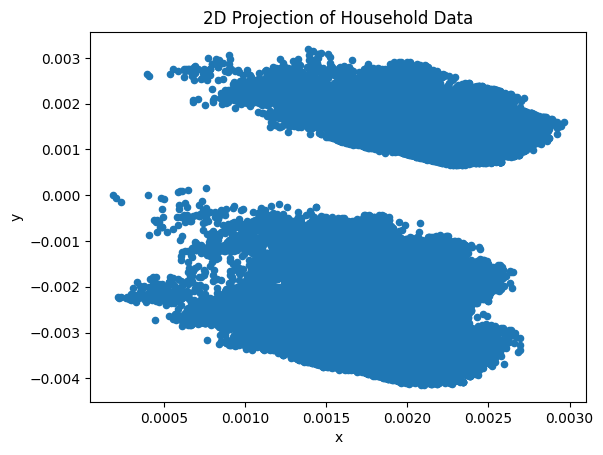

In [0]:
dense_rdd = df_combined.select("features")\
                .rdd.map(lambda row: OldVectors.fromML(row["features"]))

mat = RowMatrix(dense_rdd)
svd_rows_2d = mat.computeSVD(k=2, computeU=True).U\
          .rows.map(lambda row: (float(row[0]), float(row[1]))).toDF(["x", "y"])

svd_rows_2d.show(10, truncate=False)
df_pandas = svd_rows_2d.toPandas()\
            .plot.scatter(x="x", y="y", title='2D Projection of Household Data')

## Clustering

In [0]:
df_demo_kmeans = df_combined.select("household_id", "features")
kmeans = KMeans(k=8, seed=7, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(df_demo_kmeans)
df_clustered = kmeans.fit(df_demo_kmeans).transform(df_demo_kmeans)
centroids = model.clusterCenters()

In [0]:
centroids_data = [Row(int(i), DenseVector(centroid)) \
                        for i, centroid in enumerate(centroids)]
centroids_df = spark.createDataFrame(\
                            [Row(int(i), DenseVector(centroid)) \
                                    for i, centroid in enumerate(centroids)],\
                                                    ["centroid", "cluster_v"])

df_with_centroids = df_clustered.\
    join(centroids_df, df_clustered.cluster == centroids_df.centroid, "left")


In [0]:
@udf(DoubleType())
def euclidean_distance(vector1, vector2):
    # Ensure both vectors are DenseVector
    v1 = vector1.toArray() if isinstance(vector1, SparseVector) else vector1
    v2 = vector2.toArray() if isinstance(vector2, SparseVector) else vector2
    
    # Convert to arrays for efficient computation
    v1_array = v1.toArray() if isinstance(v1, DenseVector) else v1
    v2_array = v2.toArray() if isinstance(v2, DenseVector) else v2
    diff = v1_array - v2_array    
    return float((diff @ diff) ** 0.5)

result_df = df_with_centroids.withColumn(
    "dist",
    euclidean_distance(df_with_centroids["features"], \
            df_with_centroids["centroid"])
).select("household_id", "features", "centroid", "dist")

In [0]:
result_df.limit(10).display()

household_id,features,centroid,dist
00005229,"Map(vectorType -> dense, length -> 16, values -> List(0.375, 0.4, 0.5, 1.0, 0.7222222222222222, 0.75, 0.3333333333333333, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",1,2.363203321399072
00005882,"Map(vectorType -> dense, length -> 16, values -> List(0.5, 0.8, 0.5, 0.4666666666666667, 0.5555555555555556, 0.875, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0))",2,6.296281113816117
00007001,"Map(vectorType -> dense, length -> 16, values -> List(0.25, 0.4, 0.0, 0.6666666666666666, 0.5, 0.75, 0.6666666666666666, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",3,10.075906355702642
00008578,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.3333333333333333, 0.2222222222222222, 0.625, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",3,10.515389222174669
00008637,"Map(vectorType -> dense, length -> 16, values -> List(0.375, 0.6000000000000001, 0.5, 1.0, 0.6666666666666666, 0.75, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",1,2.444225053286033
00009768,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.5, 0.6666666666666666, 0.3333333333333333, 0.875, 0.3333333333333333, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0))",1,2.582876303658385
00011019,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0))",6,21.909918162532897
00016306,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.8666666666666667, 0.4444444444444444, 0.625, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",3,10.335774054643512
00019399,"Map(vectorType -> dense, length -> 16, values -> List(0.125, 0.2, 0.0, 0.7333333333333333, 0.5555555555555556, 0.75, 0.6666666666666666, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0))",3,10.135366587558515
00020308,"Map(vectorType -> sparse, length -> 16, indices -> List(3, 4, 5, 6, 8, 10, 13, 14, 15), values -> List(0.4666666666666667, 0.3333333333333333, 0.625, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0))",6,22.377011082805495


## Visual Clustering

In [0]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")

final_df_pca = pca.fit(result_df).transform(result_df)\
                    .select("household_id", "centroid", "dist", "pca_features")

final_df_pca.limit(10).display()

household_id,centroid,dist,pca_features
00005229,1,2.363203321399072,"Map(vectorType -> dense, length -> 2, values -> List(-1.292641885498562, -0.9834287649388476))"
00005882,2,6.296281113816117,"Map(vectorType -> dense, length -> 2, values -> List(-0.33335693828858837, -0.1929616158728556))"
00007001,3,10.075906355702642,"Map(vectorType -> dense, length -> 2, values -> List(-1.1627777044742587, -0.981123244968556))"
00008578,3,10.515389222174669,"Map(vectorType -> dense, length -> 2, values -> List(-1.0594838646293756, -0.9744428542539273))"
00008637,1,2.444225053286033,"Map(vectorType -> dense, length -> 2, values -> List(-1.3278819408613365, -0.9841632426921758))"
00009768,1,2.582876303658385,"Map(vectorType -> dense, length -> 2, values -> List(-1.1466478068356092, -0.9559418986340387))"
00011019,6,21.909918162532897,"Map(vectorType -> dense, length -> 2, values -> List(0.18282114279526906, -0.9953950996668863))"
00016306,3,10.335774054643512,"Map(vectorType -> dense, length -> 2, values -> List(-1.1316689355490543, -0.9688779495931852))"
00019399,3,10.135366587558515,"Map(vectorType -> dense, length -> 2, values -> List(-1.1204073607383385, -0.9767526020586669))"
00020308,6,22.377011082805495,"Map(vectorType -> dense, length -> 2, values -> List(0.28154518327971734, -1.0181179874884587))"


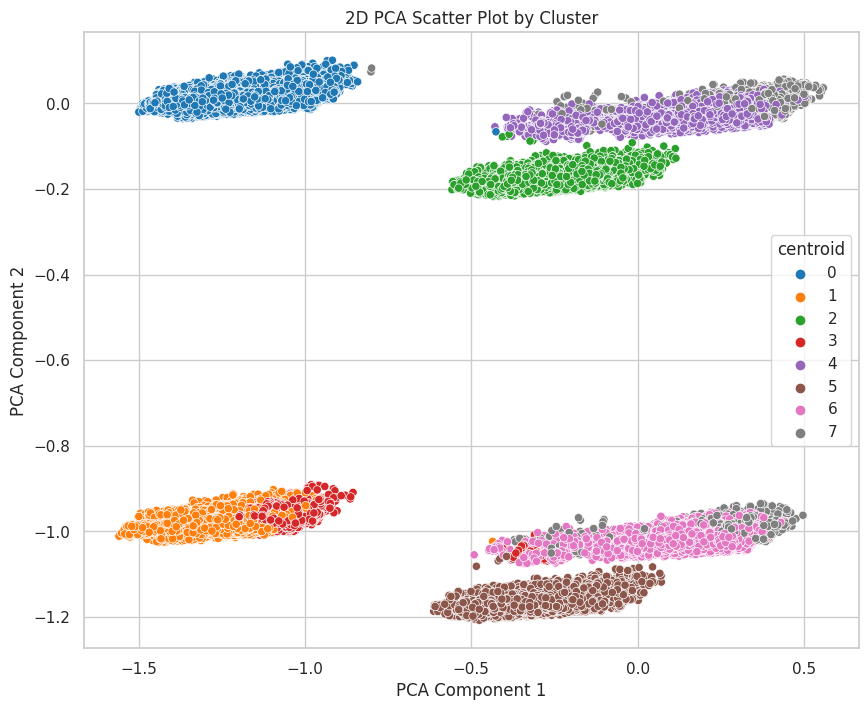

In [0]:
final_df_pca_pd = final_df_pca\
                .select("household_id", "centroid", "pca_features").toPandas()
final_df_pca_pd[['pca_x', 'pca_y']] = \
                    pd.DataFrame(final_df_pca_pd['pca_features'].tolist(),\
                        index=final_df_pca_pd.index)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(
    x="pca_x", 
    y="pca_y", 
    hue="centroid",  # Different colors for each cluster
    palette="tab10",  # More distinct colors
    data=final_df_pca_pd,
    legend="full"
)
scatter_plot.set_title("2D PCA Scatter Plot by Cluster")
scatter_plot.set_xlabel("PCA Component 1")
scatter_plot.set_ylabel("PCA Component 2")
plt.show()

## Dividing households into subsets

In [0]:
window_spec = Window.partitionBy("centroid").orderBy("dist")

# creating subsets for different groups by centroids
result_df_with_row_num = result_df\
                        .withColumn("row_num", row_number().over(window_spec))

sevenths_subset = result_df_with_row_num\
                .filter(result_df_with_row_num["row_num"] % 7 == 0)\
                        .select("household_id", "features", "centroid", "dist")

elevenths_subset = result_df_with_row_num\
                .filter(result_df_with_row_num["row_num"] % 11 == 0)\
                        .select("household_id", "features", "centroid", "dist")

total_data_clustered = result_df_with_row_num\
                                .drop(result_df_with_row_num["row_num"])

## Cluster’s Viewing Analysis

In [0]:
def process_subset_data(subset_df: DataFrame, station_view_counts:\
                                     DataFrame, window_spec) -> DataFrame:
    # Join subset data with station view counts based on household_id
    subset_pop = subset_df.join(station_view_counts, "household_id", "inner")
    
    # Aggregate by station_num and centroid to get the total view count per station
    subset_pop = subset_pop.groupBy("station_num", "centroid")\
        .agg(F.count("*").alias("view_count_rows"))
    
    # Calculate the sum of view counts across all stations within each cluster
    subset_pop = subset_pop.withColumn(
        "total_view_count",
        F.sum("view_count_rows").over(window_spec)
    )
    
    # Calculate the view percentage for each station within each cluster
    subset_pop = subset_pop.withColumn(
        "view_percentage",
        (F.col("view_count_rows") / F.col("total_view_count")) * 100
    ).select(
        F.col("station_num"),
        F.col("view_count_rows").alias("view_count"),
        F.col("centroid"),
        F.col("view_percentage")
    )
    
    return subset_pop


In [0]:
station_view_counts = static_viewing_df

# Calculate the percentage of views for each station for their subset

window_spec = Window.partitionBy("centroid")

sevenths_subset_pop = process_subset_data(sevenths_subset, \
                                            station_view_counts, window_spec)

elevenths_subset_pop = process_subset_data(elevenths_subset,\
                                             station_view_counts, window_spec)

clustered_data_views_pop = process_subset_data(total_data_clustered, \
                                            station_view_counts, window_spec)

In [0]:
demo_count_views = total_data_clustered\
                        .join(station_view_counts, "household_id", "inner")

demo_count_views = demo_count_views.groupBy("station_num")\
        .agg(F.count("*").alias("view_count_rows"))

# Calculate the sum view count using a windows
# Define a window with no partitioning and unbounded frame
window_spec = Window.orderBy(F.lit(1))\
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)


# Calculate the sum view count across all rows using the window function
demo_count_views = demo_count_views.withColumn(
        "total_view_count",
        F.lit(sum("view_count_rows").over(window_spec))
    )

demo_count_views = demo_count_views.withColumn(
        "general_view_percentage",
        (F.col("view_count_rows") / F.col("total_view_count")) * 100
    ) \
    .select(
        F.col("station_num"),
        F.col("view_count_rows").alias("view_count"),
        F.col("general_view_percentage")
    )
# Extract general popularity
general_popularity = demo_count_views\
    .select("general_view_percentage", "station_num")

In [0]:
clustered_data_views_popularity = clustered_data_views_pop\
            .join(general_popularity, \
                on=["station_num"], how="inner")\
                    .withColumn("rank_diff", col("view_percentage") - col("general_view_percentage"))

sevenths_subset_popularity = sevenths_subset_pop.join(general_popularity, \
                on=["station_num"], how="inner")\
                .withColumn("rank_diff", col("view_percentage") - col("general_view_percentage"))

elevenths_subset_popularity = elevenths_subset_pop.join(general_popularity, \
                on=["station_num"], how="inner")\
                .withColumn("rank_diff", col("view_percentage") - col("general_view_percentage"))

In [0]:
""" 
For each subset calculate the top-10 highest ’diff rank’ stations. Overall you need to return 24 groups of top ranked stations, one for each subset- 3 sets of results per cluster 
"""
x = 8
data_popularity_dict, seven_pop_dict, eleven_pop_dict = {},{},{}
for i in range(x):
    data_popularity_dict[i] = \
        clustered_data_views_popularity.filter(col("centroid") == i)\
                                .orderBy(col("rank_diff").desc()).limit(10)
    seven_pop_dict[i] = sevenths_subset_popularity.filter(col("centroid") == i)\
                                    .orderBy(col("rank_diff").desc()).limit(10)
    eleven_pop_dict[i] = elevenths_subset_popularity\
                                .filter(col("centroid") == i)\
                                    .orderBy(col("rank_diff").desc()).limit(10)


In [0]:
for i in range(x):
    displayHTML(f"<h2>Cluster #{i} - Popularity on Full Data Set</h2>")
    display(data_popularity_dict[i])
    
    displayHTML(f"<h2>Cluster #{i} - Popularity on Data (Filtered by Every 7th Row) Set</h2>")
    display(seven_pop_dict[i])
    
    displayHTML(f"<h2>Cluster #{i} - Popularity on Data (Filtered by Every 11th Row) Set</h2>")
    display(eleven_pop_dict[i])


Cluster #0 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
10171,3192,0,1.6749047634039604,0.9217651588543606,0.7531396045495998
12131,2943,0,1.544249598589554,0.8552705119606528,0.6889790866289011
99993,16389,0,8.599628498567515,8.000394341356783,0.5992341572107325
35513,1007,0,0.5283925741691067,0.15692922969918274,0.3714633444699239
70387,1428,0,0.7492994994175612,0.3853677621283255,0.3639317372892357
11118,806,0,0.4229239471502482,0.06581153588195843,0.3571124112682898
16615,1767,0,0.9271794225986211,0.6113067292644757,0.31587269333414536
47540,1210,0,0.6349106402627795,0.34304592990039,0.29186471036238953
21883,977,0,0.5126509880468889,0.2305344412151924,0.2821165468316965
10918,1510,0,0.7923265014849563,0.5148793998559257,0.27744710162903063


Cluster #0 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,2400,0,8.866558297620806,8.000394341356783,0.8661639562640229
12131,394,0,1.4555933205260825,0.8552705119606528,0.6003228085654296
10171,402,0,1.4851485148514851,0.9217651588543606,0.5633833559971245
11118,148,0,0.5467710950199498,0.06581153588195843,0.4809595591379914
16615,291,0,1.0750701935865228,0.6113067292644757,0.46376346432204707
11561,153,0,0.5652430914733265,0.17360334848597758,0.39163974298734894
35513,148,0,0.5467710950199498,0.15692922969918274,0.38984186532076703
70387,202,0,0.7462686567164178,0.3853677621283255,0.3609008945880923
60048,188,0,0.6945470666469632,0.38983903420523136,0.30470803244173184
47540,171,0,0.6317422787054825,0.34304592990039,0.2886963488050925


Cluster #0 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
12131,281,0,1.6838446788111219,0.8552705119606528,0.828574166850469
10171,291,0,1.7437679769894534,0.9217651588543606,0.8220028181350928
21883,158,0,0.9467881112176415,0.2305344412151924,0.7162536700024491
11118,84,0,0.5033557046979865,0.06581153588195843,0.4375441688160281
59684,138,0,0.826941514860978,0.4359956032491244,0.3909459116118536
18279,105,0,0.6291946308724832,0.23957013687060635,0.3896244940018768
47540,116,0,0.6951102588686481,0.34304592990039,0.35206432896825807
12729,80,0,0.4793863854266539,0.16413294582308666,0.3152534396035672
18480,115,0,0.6891179290508149,0.3867650346523586,0.3023528943984563
11809,66,0,0.39549376797698943,0.09818168268872493,0.29731208528826447


Cluster #1 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
11221,7373,1,1.122846025569761,0.8102317609359863,0.31261426463377473
16615,5382,1,0.8196334340996139,0.6113067292644757,0.20832670483513815
12131,6915,1,1.0530964691190692,0.8552705119606528,0.19782595715841633
11207,6555,1,0.9982714902495298,0.810604366942395,0.18766712330713475
11069,4251,1,0.6473916254844777,0.4700114265841966,0.17738019890028112
11158,5063,1,0.7710524111568832,0.6004856298283529,0.17056678132853031
12574,5194,1,0.7910026118010767,0.6219570509476613,0.16904556085341538
10171,7122,1,1.0846208319690542,0.9217651588543606,0.16285567311469362
74796,4031,1,0.6138874717308703,0.4582898626325856,0.15559760909828474
10918,4377,1,0.6665803680888165,0.5148793998559257,0.1517009682328908


Cluster #1 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
11221,1051,1,1.1291119657936013,0.8102317609359863,0.31888020485761503
16615,818,1,0.8787950409316517,0.6113067292644757,0.267488311667176
74796,646,1,0.6940117315915,0.4582898626325856,0.2357218689589144
14902,1072,1,1.1516727186781548,0.9497261345852894,0.20194658409286537
11207,924,1,0.9926731269203497,0.810604366942395,0.1820687599779547
61522,580,1,0.6231065082400464,0.45273182303698734,0.1703746852030591
11344,453,1,0.4866676693667949,0.3322248304642671,0.1544428389025278
10145,664,1,0.71334951977826,0.5651967359713839,0.14815278380687613
10918,608,1,0.6531875120861177,0.5148793998559257,0.13830811223019202
11164,711,1,0.7638426333770224,0.6261022927689595,0.13774034060806295


Cluster #1 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
12131,727,1,1.2312434373200556,0.8552705119606528,0.37597292535940274
74796,465,1,0.7875215933340108,0.4582898626325856,0.32923173070142525
11221,661,1,1.1194661789113574,0.8102317609359863,0.3092344179753711
11069,425,1,0.719777800359042,0.4700114265841966,0.24976637377484545
12574,501,1,0.8484910070114825,0.6219570509476613,0.2265339560638212
16615,492,1,0.8332486535921146,0.6113067292644757,0.22194192432763893
11158,480,1,0.8129255156996241,0.6004856298283529,0.21243988587127127
10145,457,1,0.773972834739017,0.5651967359713839,0.20877609876763314
11713,301,1,0.5097720421366392,0.3344138907519189,0.17535815138472027
11187,619,1,1.0483351962876402,0.8912425168293712,0.157092679458269


Cluster #2 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,28640,2,1.6415796535831317,1.477662269915791,0.16391738366734065
60179,29377,2,1.6838228171547367,1.5491249968949499,0.13469782025978683
14902,18114,2,1.038253276711063,0.9497261345852894,0.08852714212577362
99993,140970,2,8.080079740419485,8.000394341356783,0.07968539906270244
11221,15292,2,0.8765026558168033,0.8102317609359863,0.06627089488081706
61522,8970,2,0.5141399962514208,0.45273182303698734,0.06140817321443348
11069,9230,2,0.5290426048384185,0.4700114265841966,0.05903117825422188
49788,16841,2,0.965287812360109,0.9067832923466727,0.05850452001343631
11344,6737,2,0.3861495155792444,0.3322248304642671,0.05392468511497728
31709,4392,2,0.25173944966959194,0.20452964701790996,0.04720980265168198


Cluster #2 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,21162,2,8.311861743912019,8.000394341356783,0.31146740255523575
16374,4221,2,1.6578947368421053,1.477662269915791,0.18023246692631423
49788,2567,2,1.0082482325216024,0.9067832923466727,0.1014649401749298
60179,4200,2,1.6496465043205029,1.5491249968949499,0.10052150742555299
66268,1218,2,0.4783974862529458,0.39635963931738577,0.08203784693556004
11344,1042,2,0.40926944226237233,0.3322248304642671,0.07704461179810523
11221,2246,2,0.8821681068342498,0.8102317609359863,0.07193634589826359
31709,698,2,0.2741555380989788,0.20452964701790996,0.06962589108106884
14902,2572,2,1.0102120974076982,0.9497261345852894,0.06048596282240881
61522,1299,2,0.5102120974076984,0.45273182303698734,0.057480274370711015


Cluster #2 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2730,2,1.755028832616536,1.5491249968949499,0.2059038357215861
99993,12693,2,8.159919770110509,8.000394341356783,0.15952542875372622
11344,674,2,0.43329283266796526,0.3322248304642671,0.10106800220369816
16374,2452,2,1.5763116108336066,1.477662269915791,0.09864934091781552
66268,758,2,0.48729371982539715,0.39635963931738577,0.09093408050801138
11765,480,2,0.30857649804246784,0.22539558337680404,0.0831809146656638
99995,1740,2,1.118589805403946,1.0362328290732046,0.08235697633074146
12852,960,2,0.6171529960849357,0.5486778696872594,0.06847512639767628
14902,1582,2,1.0170167081316337,0.9497261345852894,0.06729057354634427
11069,834,2,0.5361516653487879,0.4700114265841966,0.0661402387645913


Cluster #3 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,9659,3,1.5480928118423731,1.3472346424224357,0.2008581694199374
58515,5445,3,0.8726954509247046,0.6785621134212684,0.1941333375034362
60048,3151,3,0.5050254115452238,0.38983903420523136,0.11518637733999249
74796,3534,3,0.566410601206227,0.4582898626325856,0.1081207385736414
11867,5335,3,0.8550652397949126,0.7518412946816703,0.10322394511324229
58574,2860,3,0.4583854893745923,0.3554506048637504,0.10293488451084187
14771,6103,3,0.9781561684101877,0.8762606503216832,0.1018955180885045
56905,3773,3,0.604716241751866,0.5062939364582557,0.09842230529361029
12131,5874,3,0.9414532743308935,0.8552705119606528,0.0861827623702407
64241,2656,3,0.4256894614611598,0.34231624313783937,0.08337321832332045


Cluster #3 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,824,3,0.9333831741824401,0.6785621134212684,0.2548210607611717
11867,804,3,0.9107282427702449,0.7518412946816703,0.15888694808857462
74796,528,3,0.5980901892819519,0.4582898626325856,0.1398003266493663
32645,1306,3,1.4793670212163432,1.3472346424224357,0.1321323787939075
11713,408,3,0.462160600808781,0.3344138907519189,0.1277467100568621
31046,341,3,0.3862665805779273,0.27263891993938943,0.11362766063853785
14771,871,3,0.9866222630010987,0.8762606503216832,0.11036161267941547
18284,323,3,0.3658771423069517,0.2635721737834414,0.10230496852351029
59684,471,3,0.5335236347571958,0.4359956032491244,0.09752803150807138
12852,569,3,0.644532798676952,0.5486778696872594,0.09585492898969261


Cluster #3 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,564,3,1.0126036841538295,0.6785621134212684,0.33404157073256113
32645,933,3,1.6751050307012818,1.3472346424224357,0.32787038827884607
10179,627,3,1.1257136701497361,0.8952790818988002,0.23043458825093588
58574,284,3,0.5098926352831341,0.3554506048637504,0.1544420304193837
18151,143,3,0.2567417142446766,0.11021375164567654,0.14652796259900008
56905,361,3,0.6481381737225753,0.5062939364582557,0.1418442372643196
31046,229,3,0.41114582211210454,0.27263891993938943,0.1385069021727151
51529,269,3,0.48296168623648966,0.3586022306679584,0.12435945556853129
75003,87,3,0.15619950447053754,0.03882865091785279,0.11737085355268476
45507,338,3,0.6068440518510538,0.4895732419206597,0.11727080993039413


Cluster #4 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99995,11012,4,1.194371745494262,1.0362328290732046,0.15813891642105737
59684,5447,4,0.5907866779610648,0.4359956032491244,0.15479107471194037
10171,9924,4,1.0763662552020574,0.9217651588543606,0.1546010963476968
32645,13575,4,1.4723571054381224,1.3472346424224357,0.12512246301568664
12131,8905,4,0.9658445689816929,0.8552705119606528,0.11057405702104006
60179,15193,4,1.6478468878763457,1.5491249968949499,0.09872189098139583
11713,3881,4,0.4209368638088658,0.3344138907519189,0.0865229730569469
74796,4976,4,0.5397015806011122,0.4582898626325856,0.08141171796852659
18001,2278,4,0.24707399529930335,0.19287018406736717,0.05420381123193618
18279,2708,4,0.29371219458758274,0.23957013687060635,0.05414205771697639


Cluster #4 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2375,4,1.8070318265858132,1.5491249968949499,0.2579068296908633
99995,1617,4,1.2303033530902145,1.0362328290732046,0.19407052401700997
16374,2124,4,1.616057094597165,1.477662269915791,0.13839482468137398
12131,1276,4,0.9708516255677884,0.8552705119606528,0.11558111360713552
45507,755,4,0.5744459069778058,0.4895732419206597,0.08487266505714613
32645,1872,4,1.4243215071025863,1.3472346424224357,0.07708686468015058
59684,666,4,0.5067297669499585,0.4359956032491244,0.07073416370083413
19628,266,4,0.20238756457761106,0.13198015252005862,0.07040741205755244
49788,1283,4,0.9761776141093045,0.9067832923466727,0.06939432176263183
11317,227,4,0.1727141998463072,0.11398638746056586,0.058727812385741346


Cluster #4 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,1362,4,1.627084627514694,1.3472346424224357,0.2798499850922582
59684,516,4,0.6164285372963157,0.4359956032491244,0.18043293404719135
12131,846,4,1.010656090218378,0.8552705119606528,0.15538557825772525
74796,508,4,0.6068715057103263,0.4582898626325856,0.14858164307774074
99995,990,4,1.1826826587661872,1.0362328290732046,0.1464498296929826
45507,524,4,0.6259855688823052,0.4895732419206597,0.13641232696164546
10171,868,4,1.0369379270798489,0.9217651588543606,0.11517276822548828
34742,167,4,0.19950303435752856,0.0935862086096828,0.10591682574784576
15433,269,4,0.3213551870788933,0.21694984723153737,0.10440533984735595
58812,332,4,0.39661681081855976,0.29626835084581565,0.10034845997274411


Cluster #5 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,16391,5,1.5724516373508828,1.3472346424224357,0.22521699492844705
99993,85241,5,8.177496798207956,8.000394341356783,0.17710245685117343
60179,17573,5,1.6858454409838974,1.5491249968949499,0.13672044408894757
31709,3127,5,0.2999851302541767,0.20452964701790996,0.09545548323626676
30754,2819,5,0.2704375062956585,0.17632026728270858,0.09411723901294991
57708,4713,5,0.4521362068717412,0.3595647961845145,0.09257141068722674
49788,10386,5,0.996368904003799,0.9067832923466727,0.08958561165712631
45507,6008,5,0.5763705348791474,0.4895732419206597,0.08679729295848765
58515,7925,5,0.7602757138677169,0.6785621134212684,0.08171360044644849
56905,6121,5,0.5872110592535388,0.5062939364582557,0.08091712279528307


Cluster #5 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,12310,5,8.35726457429547,8.000394341356783,0.3568702329386877
60179,2509,5,1.7033612361419446,1.5491249968949499,0.1542362392469947
32645,2207,5,1.4983332993883107,1.3472346424224357,0.151098656965875
56905,909,5,0.6171205116193812,0.5062939364582557,0.11082657516112548
14771,1429,5,0.9701487470892143,0.8762606503216832,0.09388809676753107
49788,1463,5,0.9932313624853188,0.9067832923466727,0.0864480701386462
31046,526,5,0.3571016381867927,0.27263891993938943,0.08446271824740326
45507,843,5,0.5723130817328256,0.4895732419206597,0.08273983981216587
65732,539,5,0.3659273440735385,0.2925888665325285,0.07333847754100997
57708,635,5,0.4311017875448923,0.3595647961845145,0.07153699136037783


Cluster #5 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,1540,5,1.6252268985605132,1.3472346424224357,0.27799225613807743
60179,1627,5,1.7170416649077629,1.5491249968949499,0.16791666801281302
45507,602,5,0.6353159694372915,0.4895732419206597,0.1457427275166318
57708,469,5,0.4949554645616108,0.3595647961845145,0.13539066837709635
11713,430,5,0.45379712102663683,0.3344138907519189,0.11938323027471792
31709,304,5,0.320824011144413,0.20452964701790996,0.11629436412650304
49788,963,5,1.016294482671282,0.9067832923466727,0.10951119032460943
34540,281,5,0.29655114188019754,0.19066559852944828,0.10588554335074926
61854,342,5,0.3609270125374646,0.26604068857589985,0.09488632396156477
59337,461,5,0.48651272742623153,0.3975861340884815,0.08892659333775005


Cluster #6 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,17124,6,1.992390659359838,1.5491249968949499,0.4432656624648881
16374,15144,6,1.76201612621732,1.477662269915791,0.2843538563015289
11187,8409,6,0.9783936612098153,0.8912425168293712,0.08715114438044413
61854,2947,6,0.34288573190454585,0.26604068857589985,0.076845043328646
14765,4703,6,0.5471976916006376,0.47915579899147975,0.06804189260915783
19630,1949,6,0.2267676591387716,0.16206808753757113,0.06469957160120046
12852,5222,6,0.6075837434698128,0.5486778696872594,0.05890587378255341
11066,5559,6,0.6467939544137666,0.5880809548649923,0.05871299954877429
64241,3434,6,0.3995485589956601,0.34231624313783937,0.05723231585782074
58646,5750,6,0.6690169523078177,0.6139770723104057,0.055039879997412


Cluster #6 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2490,6,2.0653616456536166,1.5491249968949499,0.5162366487586667
16374,2320,6,1.9243530192435303,1.477662269915791,0.4466907493277392
61854,470,6,0.38984737889847376,0.26604068857589985,0.12380669032257391
99995,1381,6,1.145487723954877,1.0362328290732046,0.1092548948816725
58646,855,6,0.7091904445919044,0.6139770723104057,0.09521337228149873
64241,520,6,0.43132050431320507,0.34231624313783937,0.0890042611753657
32645,1716,6,1.4233576642335766,1.3472346424224357,0.07612302181114083
10335,298,6,0.24717982747179826,0.1749229947586755,0.07225683271312275
11187,1159,6,0.9613470471134705,0.8912425168293712,0.07010453028409935
32797,169,6,0.14017916390179164,0.07101249472141491,0.06916666918037673


Cluster #6 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,1479,6,1.8796705810584107,1.5491249968949499,0.3305455841634608
16374,1324,6,1.682680087438361,1.477662269915791,0.20501781752256987
19630,243,6,0.30883025773982004,0.16206808753757113,0.1467621702022489
10335,227,6,0.2884957551725891,0.1749229947586755,0.11357276041391356
64241,354,6,0.44990086929998474,0.34231624313783937,0.10758462616214537
32645,1139,6,1.4475624015047532,1.3472346424224357,0.1003277590823175
15433,248,6,0.3151847897920797,0.21694984723153737,0.09823494256054233
10142,757,6,0.9620761527121142,0.8874388305139478,0.07463732219816643
29931,79,6,0.1004016064257028,0.027417591971582583,0.07298401445412021
11713,318,6,0.4041482385237151,0.3344138907519189,0.06973434777179621


Cluster #7 - Popularity on Full Data Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,36356,7,9.055697671811911,8.000394341356783,1.0553033304551285
10171,4873,7,1.2137863008785192,0.9217651588543606,0.29202114202415863
12131,4599,7,1.145537286628424,0.8552705119606528,0.29026677466777107
11118,1388,7,0.34572858313551913,0.06581153588195843,0.2799170472535607
70387,2611,7,0.650358307324813,0.3853677621283255,0.2649905451964875
10642,1729,7,0.430666224957718,0.18490573068037855,0.24576049427733945
11809,1258,7,0.3133476639657659,0.09818168268872493,0.21516598127704098
10222,1013,7,0.2523220855304617,0.046063417542290784,0.2062586679881709
14909,2674,7,0.6660505989224627,0.4622332762004124,0.20381732272205028
35513,1437,7,0.35793369882257997,0.15692922969918274,0.20100446912339723


Cluster #7 - Popularity on Data (Filtered by Every 7th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5191,7,8.901044256588762,8.000394341356783,0.9006499152319787
11118,201,7,0.3446561155026664,0.06581153588195843,0.27884457962070797
12131,660,7,1.131706647919203,0.8552705119606528,0.2764361359585502
10642,258,7,0.4423944169138703,0.18490573068037855,0.25748868623349175
14765,420,7,0.7201769577667655,0.47915579899147975,0.24102115877528574
14767,295,7,0.5058385774790377,0.26521785031174705,0.24062072716729066
70387,353,7,0.6052915859325434,0.3853677621283255,0.21992382380421788
11809,176,7,0.3017884394451208,0.09818168268872493,0.20360675675639586
14909,384,7,0.6584475042439,0.4622332762004124,0.1962142280434876
10222,141,7,0.241773692964557,0.046063417542290784,0.1957102754222662


Cluster #7 - Popularity on Data (Filtered by Every 11th Row) Set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,3264,7,8.989259157256955,8.000394341356783,0.9888648159001718
10171,510,7,1.404571743321399,0.9217651588543606,0.4828065844670383
12131,480,7,1.321949876067199,0.8552705119606528,0.4666793641065462
11561,215,7,0.592123381988433,0.17360334848597758,0.41852003350245537
14909,297,7,0.8179564858165794,0.4622332762004124,0.35572320961616705
11367,155,7,0.42687964748003304,0.11876816454281243,0.3081114829372206
11118,132,7,0.3635362159184798,0.06581153588195843,0.29772468003652136
35070,167,7,0.459928394381713,0.1666790868668803,0.2932493075148327
70387,231,7,0.6361883778573395,0.3853677621283255,0.250820615729014
14767,184,7,0.5067474524924264,0.26521785031174705,0.24152960218067931


Start -
**Calculating Statistics in order to compare results of subsets/clusters**

In [0]:
from pyspark.sql.functions import avg, stddev, expr

# Function to calculate summary statistics for a given DataFrame
def calculate_stats_by_cluster(df, subset_name):
    return df.groupBy("centroid").agg(
        avg("view_percentage").alias(f"{subset_name}_avg_view_percentage"),
        avg("general_view_percentage").alias(f"{subset_name}_avg_general_view_percentage"),
        avg("rank_diff").alias(f"{subset_name}_avg_rank_diff"),
        stddev("view_percentage").alias(f"{subset_name}_stddev_view_percentage"),
        stddev("general_view_percentage").alias(f"{subset_name}_stddev_general_view_percentage"),
        stddev("rank_diff").alias(f"{subset_name}_stddev_rank_diff")
    )

# Calculate stats for each subset
sevenths_cluster_stats = calculate_stats_by_cluster(sevenths_subset_popularity, "sevenths")
elevenths_cluster_stats = calculate_stats_by_cluster(elevenths_subset_popularity, "elevenths")
full_cluster_stats = calculate_stats_by_cluster(clustered_data_views_popularity, "full")

# Display the statistics for each subset
sevenths_cluster_stats.display()
elevenths_cluster_stats.display()
full_cluster_stats.display()


centroid,sevenths_avg_view_percentage,sevenths_avg_general_view_percentage,sevenths_avg_rank_diff,sevenths_stddev_view_percentage,sevenths_stddev_general_view_percentage,sevenths_stddev_rank_diff
0,0.0744601638123603,0.0711049757356638,0.0033551880766965773,0.28320430035320027,0.2578827240732215,0.07275163259015824
7,0.05998800239952009,0.059002479629269765,9.85522770250332E-4,0.2549193680901976,0.23283744756595967,0.04888156483415975
6,0.049900199600798424,0.04967220153924208,2.279980615562975E-4,0.21460703237080267,0.2133683930393906,0.022245241658503324
5,0.04970178926441351,0.0494755002538116,2.2628901060191308E-4,0.21974709999925604,0.21296612495072367,0.01575638695457326
1,0.052002080083203304,0.05171420496683744,2.8787511636590833E-4,0.20610673018256642,0.21758095232069244,0.036627940188805365
3,0.05299417064122947,0.05264659262173761,3.4757801949185553E-4,0.21135690591399897,0.21954125802935517,0.024219873775742973
2,0.04470272686633883,0.04461331613804641,8.941072829244711E-5,0.20706949861221646,0.20249057287767847,0.012947946034352736
4,0.04812319538017324,0.04797350148491323,1.4969389526000952E-4,0.21104555843135434,0.2097196561431769,0.014536548205686487


centroid,elevenths_avg_view_percentage,elevenths_avg_general_view_percentage,elevenths_avg_rank_diff,elevenths_stddev_view_percentage,elevenths_stddev_general_view_percentage,elevenths_stddev_rank_diff
0,0.08561643835616432,0.07983984896185838,0.005776589394305964,0.2801364283263304,0.27534418473406613,0.07850048947023718
7,0.06591957811470009,0.06419444341693283,0.0017251346977672402,0.26851298141121355,0.24345419403388552,0.05889411032664815
6,0.05321979776476852,0.05286274179614708,3.570559686214053E-4,0.20987868194206816,0.21998319790931728,0.025189036466724806
5,0.05257623554153524,0.052224093153643424,3.5214238789176055E-4,0.2199234816961371,0.2187245812612114,0.018725972592524887
1,0.059031877213695384,0.05833678774734198,6.950894663534146E-4,0.218335713099126,0.23103040917297382,0.04216733889710123
3,0.0582750582750583,0.057576503439179506,6.985548358787793E-4,0.220522793010641,0.22964043820402705,0.030572408499624497
2,0.04743833017077796,0.047299626642182624,1.3870352859537795E-4,0.2126852666653432,0.20829679489573816,0.013853472229548565
4,0.0531914893617021,0.0528421960050294,3.492933566727393E-4,0.2210154216590307,0.2199266230857795,0.019462449605713715


centroid,full_avg_view_percentage,full_avg_general_view_percentage,full_avg_rank_diff,full_stddev_view_percentage,full_stddev_general_view_percentage,full_stddev_rank_diff
0,0.04800768122899665,0.047715436839668564,2.922443893280913E-4,0.2236639645428829,0.20950946947113622,0.05235333434753992
7,0.04264392324093818,0.042570626846180654,7.329639475750012E-5,0.21637328196644937,0.19798920432141429,0.04073363828409119
6,0.039215686274509824,0.03920326607429617,1.2420200213627715E-5,0.18963518982835248,0.1902024028839153,0.016117150895427278
5,0.0390777647518562,0.039065721914114865,1.2042837741329807E-5,0.19376780441628427,0.18988163306184555,0.012111702551878252
1,0.04001600640256103,0.03999849312504889,1.7513277512113187E-5,0.18402017707170695,0.19205187760532688,0.02771963681477911
3,0.040485829959514164,0.040464239176248064,2.1590783266098782E-5,0.18556232585519605,0.19312805654266652,0.0189109863610662
2,0.03762227238525208,0.0376179968084291,4.27557682297573E-6,0.18810631395302896,0.18645594463363496,0.008885485449463427
4,0.03901677721420213,0.03900681270515439,9.964509047706387E-6,0.1891109117041676,0.18973919469073589,0.010922370106244696


In [0]:
# Function to calculate ranks for each column
def calculate_ranks(df, column_name):
    window_asc = Window.orderBy(F.asc(column_name))
    window_desc = Window.orderBy(F.desc(column_name))
    
    df = df.withColumn(f"{column_name}_rank_asc", F.row_number().over(window_asc))
    df = df.withColumn(f"{column_name}_rank_desc", F.row_number().over(window_desc))
    
    return df

# Function to get extreme clusters based on ranking
def get_extreme_clusters(df, column_name):
    # Highest value
    highest_cluster = df.filter(F.col(f"{column_name}_rank_desc") == 1).select("centroid", column_name)\
                                                                                                    .collect()
    # Lowest value
    lowest_cluster = df.filter(F.col(f"{column_name}_rank_asc") == 1).select("centroid", column_name).collect()
    
    # Middle value (approximate median)
    median_rank = (df.count() // 2) + 1
    middle_cluster = df.filter(F.col(f"{column_name}_rank_asc") == median_rank)\
                .select("centroid", column_name).collect()
    return highest_cluster, middle_cluster, lowest_cluster

# Function to process and print results
def process_and_print(df, name):
    print(f"Checking table {name} results:")
    
    # List of columns to evaluate
    columns_to_check = [
        f"{name}_avg_view_percentage",
        f"{name}_avg_rank_diff",
        f"{name}_stddev_view_percentage"
    ]
    
    for col_name in columns_to_check:
        df_ranked = calculate_ranks(df, col_name)
        
        highest_cluster, middle_cluster, lowest_cluster = get_extreme_clusters(df_ranked, col_name)
        
        print(f"\nFor {col_name}:")
        print(f"  Highest: Cluster {highest_cluster[0]['centroid']} with value {highest_cluster[0][col_name]}")
        print(f"  Middle: Cluster {middle_cluster[0]['centroid']} with value {middle_cluster[0][col_name]}")
        print(f"  Lowest: Cluster {lowest_cluster[0]['centroid']} with value {lowest_cluster[0][col_name]}")

# Process each DataFrame
for df, name in [(sevenths_cluster_stats, "sevenths"), (elevenths_cluster_stats, "elevenths"), (full_cluster_stats, "full")]:
    process_and_print(df, name)


Checking table sevenths results:

For sevenths_avg_view_percentage:
  Highest: Cluster 0 with value 0.07457121551081283
  Middle: Cluster 3 with value 0.05219206680584552
  Lowest: Cluster 2 with value 0.04474272930648769

For sevenths_avg_rank_diff:
  Highest: Cluster 0 with value 0.003730304883270004
  Middle: Cluster 1 with value 0.00032378425847299613
  Lowest: Cluster 2 with value 8.022534457184039e-05

For sevenths_stddev_view_percentage:
  Highest: Cluster 0 with value 0.2790316701994497
  Middle: Cluster 4 with value 0.21148151216782468
  Lowest: Cluster 2 with value 0.20662652581793584
Checking table elevenths results:

For elevenths_avg_view_percentage:
  Highest: Cluster 0 with value 0.08718395815170005
  Middle: Cluster 3 with value 0.05803830528148577
  Lowest: Cluster 2 with value 0.047687172150691466

For elevenths_avg_rank_diff:
  Highest: Cluster 0 with value 0.005805506731320231
  Middle: Cluster 3 with value 0.0005921444137890031
  Lowest: Cluster 2 with value 0.0001

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Ensure that 'rank_diff' is calculated in each DataFrame
clustered_data_views_popularity_check = clustered_data_views_pop\
    .withColumnRenamed("centroid", "clustered_centroid")\
    .join(general_popularity, on=["station_num"], how="inner")\
    .withColumn("rank_diff", F.col("view_percentage") - F.col("general_view_percentage"))\
    .withColumn("subset_type", F.lit("full"))\
    .select(F.col("clustered_centroid").alias("centroid"), "subset_type", "rank_diff")

sevenths_subset_popularity_check = sevenths_subset_pop\
    .withColumnRenamed("centroid", "sevenths_centroid")\
    .join(general_popularity, on=["station_num"], how="inner")\
    .withColumn("rank_diff", F.col("view_percentage") - F.col("general_view_percentage"))\
    .withColumn("subset_type", F.lit("sevenths"))\
    .select(F.col("sevenths_centroid").alias("centroid"), "subset_type", "rank_diff")

elevenths_subset_popularity_check = elevenths_subset_pop\
    .withColumnRenamed("centroid", "elevenths_centroid")\
    .join(general_popularity, on=["station_num"], how="inner")\
    .withColumn("rank_diff", F.col("view_percentage") - F.col("general_view_percentage"))\
    .withColumn("subset_type", F.lit("elevenths"))\
    .select(F.col("elevenths_centroid").alias("centroid"), "subset_type", "rank_diff")

# Union all DataFrames
combined_df = clustered_data_views_popularity_check\
    .union(sevenths_subset_popularity_check)\
    .union(elevenths_subset_popularity_check)

# Define the column to check
metric_column = "rank_diff"

# Function to calculate summary statistics and rank
def summarize_metrics(df, metric):
    # Group by centroid and subset_type and calculate average and standard deviation
    summary_df = df.groupBy("centroid", "subset_type").agg(
        F.avg(metric).alias(f"avg_{metric}"),
        F.stddev(metric).alias(f"stddev_{metric}")
    )
    
    # Rank metrics within each centroid
    window = Window.partitionBy("centroid").orderBy(F.desc(f"avg_{metric}"))
    ranked_df = summary_df.withColumn(f"{metric}_rank", F.row_number().over(window))
    
    return summary_df, ranked_df

# Compute summary statistics
summary_df, ranked_df = summarize_metrics(combined_df, metric_column)

# Get highest, middle, and lowest clusters for each metric within each centroid
def get_extreme_clusters(df, metric):
    count = df.count()
    
    if count == 0:
        return [], [], []  # Handle case when DataFrame is empty
    
    highest = df.filter(F.col(f"{metric}_rank") == 1).select("centroid", "subset_type", f"avg_{metric}").collect()
    lowest = df.filter(F.col(f"{metric}_rank") == count).select("centroid", "subset_type", f"avg_{metric}").collect()
    median_rank = (count // 2) + 1
    middle = df.filter(F.col(f"{metric}_rank") == median_rank).select("centroid", "subset_type", f"avg_{metric}").collect()
    
    return highest, middle, lowest

# Print results for each cluster
for centroid in ranked_df.select("centroid").distinct().collect():
    centroid_value = centroid["centroid"]
    centroid_df = ranked_df.filter(F.col("centroid") == centroid_value)
    
    highest, middle, lowest = get_extreme_clusters(centroid_df, metric_column)
    
    if highest and middle and lowest:  # Ensure there are results to print
        print(f"\nFor Cluster {centroid_value}:")
        print(f"  Highest: Subset {highest[0]['subset_type']} with value {highest[0][f'avg_{metric_column}']}")
        print(f"  Middle: Subset {middle[0]['subset_type']} with value {middle[0][f'avg_{metric_column}']}")
        print(f"  Lowest: Subset {lowest[0]['subset_type']} with value {lowest[0][f'avg_{metric_column}']}")



For Cluster 0:
  Highest: Subset elevenths with value 0.006116228711717073
  Middle: Subset sevenths with value 0.00335894301450459
  Lowest: Subset full with value 0.0002922443893280915

For Cluster 7:
  Highest: Subset elevenths with value 0.0018159906871739926
  Middle: Subset sevenths with value 0.000963656988696112
  Lowest: Subset full with value 7.329639475749983e-05

For Cluster 6:
  Highest: Subset elevenths with value 0.0003444971322411404
  Middle: Subset sevenths with value 0.00021769167750667316
  Lowest: Subset full with value 1.2420200213627749e-05

For Cluster 5:
  Highest: Subset elevenths with value 0.000293305463378187
  Middle: Subset sevenths with value 0.00020256245249885313
  Lowest: Subset full with value 1.2042837741329807e-05

For Cluster 1:
  Highest: Subset elevenths with value 0.0006195528319193443
  Middle: Subset sevenths with value 0.00036779899041705313
  Lowest: Subset full with value 1.7513277512113305e-05

For Cluster 3:
  Highest: Subset elevenths 

Finish - **Calculating statistics for comparing results**

# Dynamic Data Analysis - Streaming

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(f.from_csv(f.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

viewing_counts = streaming_df.groupBy("event_date").count()
count_viewing_query =viewing_counts.writeStream\
.queryName('num_viewing')\
.format("memory")\
.outputMode("complete")\
.start()

time.sleep(10)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewing_query.status)
    spark.sql('SELECT * FROM num_viewing').show()
    time.sleep(5)
    
count_viewing_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
+----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|12582|
|  20151004|18896|
|  20151018|18522|
+----------+-----+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|30085|
|  20151004|35537|
|  20151018|34378|
+----------+-----+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+-----+
|event_date|count|
+----------+-----+
|  20150913|64487|
|  20151004|70127|
|  20151018|65386|
+----------+-----+

Batch number: 4
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+----------+----

In [0]:
from pyspark.sql.functions import col, count, max as spark_max
window_spec = Window.partitionBy("centroid").orderBy("dist")

result_df_with_row_num = result_df\
                        .withColumn("row_num", row_number().over(window_spec))

sevenths_subset = result_df_with_row_num\
                .filter(result_df_with_row_num["row_num"] % 7 == 0)\
                        .select("household_id", "features", "centroid", "dist")\
                            .withColumn(\
                                "household_id",  F.regexp_replace(F.col("household_id"), "^0+", ""))

# Path to external storage
external_storage_path = \
    "/Workspace/Users/gil.caplan@campus.technion.ac.il/storage"
schema = StructType([
            StructField("household_id", StringType(), True),
            StructField("station_num", StringType(), True),
            StructField("view_count_rows", LongType(), True)
        ])
def read_batches_from_file():
    if os.path.exists(external_storage_path):
        return spark.read.format("parquet").load(external_storage_path)
    return spark.createDataFrame([], schema)

def write_batches_to_file(df):
    df.write.mode("overwrite").parquet(external_storage_path)

write_batches_to_file(station_view_counts)
def process_batch(batch_df, batch_id):
    displayHTML(f"<h1>Processing batch {batch_id}:</h1>")
    batch_df = batch_df.withColumn(\
                            "household_id",  F.regexp_replace(F.col("household_id"), "^0+", ""))
    station_views = batch_df\
                            .groupby("household_id", "station_num") \
                                .agg(count("*").alias("view_count_rows"))
    batches = read_batches_from_file()

    # Aggregate counts from previous and current batch
    aggregated_batches = batches.union(station_views)\
        .groupBy("household_id", "station_num")\
        .agg(count("*").alias("view_count_rows"))

    write_batches_to_file(batches.union(station_views))
    if aggregated_batches.count() > 0:
        station_view_counts = aggregated_batches
    else:
        station_view_counts = station_views

    # Update the external storage with aggregated batches
    
    window_spec = Window.partitionBy("centroid")
    sevenths_batch = process_subset_data(sevenths_subset, station_view_counts, window_spec)
    clustered_data_views_pop = process_subset_data(total_data_clustered, station_view_counts, window_spec)
    
    # views over all the data
    demo_count_views = total_data_clustered.join(station_view_counts, "household_id", "inner")

    # Calculate the maximum view count within the DataFrame using a window function
    window_spec = Window.orderBy(F.lit(1))\
        .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

    demo_count_views = demo_count_views.groupBy("station_num")\
            .agg(F.count("*").alias("view_count_rows"))
    demo_count_views = demo_count_views.withColumn(
        "total_view_count",
        F.lit(sum("view_count_rows").over(window_spec))
    )
    # Calculate the percentage of views for each station
    demo_count_views = demo_count_views\
        .withColumn(
            "general_view_percentage",
            (F.col("view_count_rows") / F.col("total_view_count")) * 100
        ) \
        .select(
            F.col("station_num"),
            F.col("view_count_rows").alias("view_count"),
            F.col("general_view_percentage")
        )
        

    # Extract general popularity
    general_popularity = demo_count_views.select("general_view_percentage", "station_num")

    sevenths_batch_pop = sevenths_batch.join(general_popularity, \
                on=["station_num"], how="inner")\
                .withColumn("rank_diff", col("view_percentage") - col("general_view_percentage"))
    seven_pop_dict = {i  : sevenths_subset_popularity.filter(col("centroid") == i)\
        .orderBy(col("rank_diff").desc()).limit(10) for i in range(10)}

    displayHTML(f"<h1>Results for batch {batch_id}:</h1>")
    for i in range(x):
        displayHTML(f"<h2>Cluster #{i} - Populatriy on data (filtered by every 7th row) set</h2>")
        seven_pop_dict[i].display()


# Set up a streaming query to process each trigger
query = streaming_df.writeStream \
    .foreachBatch(process_batch) \
    .outputMode("append") \
    .start()

# Allow the streaming query to run for sufficient time to process multiple batches
time.sleep(720)
query.stop()


Processing batch 0:

Results for batch 0:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,2348,0,8.794666267136115,8.000394341356783,0.7942719257793325
10171,447,0,1.6742827178065771,0.9217651588543606,0.7525175589522165
12131,414,0,1.5506779534047495,0.8552705119606528,0.6954074414440966
16615,296,0,1.1086972806951831,0.6113067292644757,0.49739055143070743
11118,143,0,0.535620645741254,0.06581153588195843,0.4698091098592956
35513,145,0,0.5431118435837891,0.15692922969918274,0.3861826138846063
70387,203,0,0.7603565810173046,0.3853677621283255,0.3749888188889791
47540,187,0,0.7004269982770245,0.34304592990039,0.35738106837663447
59684,207,0,0.7753389767023747,0.4359956032491244,0.33934337345325033
11561,119,0,0.4457262716308337,0.17360334848597758,0.27212292314485614


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
11221,1046,1,1.1057666895713305,0.8102317609359863,0.29553492863534425
14902,1091,1,1.1533379142660818,0.9497261345852894,0.20361177968079236
15433,386,1,0.4080553940483112,0.21694984723153737,0.19110554681677383
11713,495,1,0.5232834716422644,0.3344138907519189,0.1888695808903455
74796,608,1,0.6427401025424176,0.4582898626325856,0.18445023990983206
11207,941,1,0.9947671652835773,0.810604366942395,0.18416279834118232
16615,748,1,0.7907394682594218,0.6113067292644757,0.17943273899494605
12574,749,1,0.7917966065859717,0.6219570509476613,0.16983955563831044
11164,749,1,0.7917966065859717,0.6261022927689595,0.16569431381701227
11066,679,1,0.7177969237274697,0.5880809548649923,0.12971596886247738


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,4255,2,1.686865443243222,1.477662269915791,0.20920317332743088
99993,20588,2,8.161970798000342,8.000394341356783,0.16157645664355869
11221,2335,2,0.9256946674436951,0.8102317609359863,0.11546290650770885
12852,1641,2,0.650563147441158,0.5486778696872594,0.10188527775389855
11066,1731,2,0.6862430275567607,0.5880809548649923,0.09816207269176835
11069,1421,2,0.5633456627141289,0.4700114265841966,0.0933342361299323
61522,1370,2,0.5431270639819539,0.45273182303698734,0.09039524094496654
66268,1218,2,0.48286771089782476,0.39635963931738577,0.086508071580439
14902,2597,2,1.0295627628913389,0.9497261345852894,0.07983662830604943
49788,2468,2,0.9784216013923082,0.9067832923466727,0.0716383090456355


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,802,3,0.9080821576575556,0.6785621134212684,0.22952004423628725
32645,1382,3,1.5647999275345907,1.3472346424224357,0.217565285112155
74796,529,3,0.5989718970085373,0.4582898626325856,0.14068203437595167
14771,892,3,1.009986639190199,0.8762606503216832,0.13372598886851583
18284,333,3,0.3770465816707806,0.2635721737834414,0.1134744078873392
11867,762,3,0.8627912769763808,0.7518412946816703,0.11094998229471054
56905,543,3,0.6148237052469485,0.5062939364582557,0.1085297687886928
11713,383,3,0.4336601825222492,0.3344138907519189,0.09924629177033029
60048,431,3,0.48800923933965895,0.38983903420523136,0.09817020513442759
58574,397,3,0.44951199076066034,0.3554506048637504,0.09406138589690993


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2339,4,1.772627717864965,1.5491249968949499,0.2235027209700151
99995,1608,4,1.2186341899644566,1.0362328290732046,0.18240136089125203
10171,1456,4,1.1034399133011497,0.9217651588543606,0.18167475444678904
12131,1340,4,1.015528491637047,0.8552705119606528,0.1602579796763942
45507,769,4,0.5827920970663352,0.4895732419206597,0.09321885514567546
32645,1896,4,1.4368970299580905,1.3472346424224357,0.08966238753565481
59684,687,4,0.5206478162348144,0.4359956032491244,0.08465221298568998
18284,443,4,0.33573068790687455,0.2635721737834414,0.07215851412343316
11713,532,4,0.40317996832157393,0.3344138907519189,0.06876607756965503
70225,310,4,0.23493569582648102,0.167005117122488,0.06793057870399302


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,12588,5,8.422320353271779,8.000394341356783,0.4219260119149961
32645,2219,5,1.4846781747624782,1.3472346424224357,0.13744353234004247
56905,958,5,0.6409741736919577,0.5062939364582557,0.13468023723370204
14776,527,5,0.35260270306436503,0.2582780634423827,0.09432463962198234
11150,1139,5,0.762076809848789,0.6869302233151998,0.07514658653358919
45507,839,5,0.5613542084838753,0.4895732419206597,0.07178096656321559
14765,813,5,0.543958249698916,0.47915579899147975,0.06480245070743629
57708,634,5,0.42419376421785093,0.3595647961845145,0.06462896803333645
15952,410,5,0.2743208885320487,0.21024293911617856,0.06407794941587017
14771,1398,5,0.9353673223604978,0.8762606503216832,0.05910667203881459


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,2378,6,1.9316215711280247,1.477662269915791,0.4539593012122336
60179,2333,6,1.8950685977467123,1.5491249968949499,0.34594360085176246
11187,1256,6,1.0202341014873,0.8912425168293712,0.12899158465792882
19630,329,6,0.2672428498322625,0.16206808753757113,0.10517476229469136
32797,203,6,0.16489452436458746,0.07101249472141491,0.09388202964317255
64241,532,6,0.43213737419684994,0.34231624313783937,0.08982113105901057
20290,261,6,0.21200724561161247,0.1245435576421492,0.08746368796946327
10142,1197,6,0.9723090919429124,0.8874388305139478,0.08487026142896459
99995,1368,6,1.1112103907918998,1.0362328290732046,0.07497756171869518
32645,1749,6,1.4206922320870123,1.3472346424224357,0.0734575896645766


Cluster #7 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5236,7,8.893569317525563,8.000394341356783,0.8931749761687797
10642,291,7,0.494275911268132,0.18490573068037855,0.30937018058775345
14909,448,7,0.7609471073818663,0.4622332762004124,0.29871383118145395
11118,200,7,0.33970853008119034,0.06581153588195843,0.2738969941992319
12131,658,7,1.1176410639671164,0.8552705119606528,0.26237055200646353
70387,365,7,0.6199680673981723,0.3853677621283255,0.23460030526984682
10222,160,7,0.2717668240649523,0.046063417542290784,0.2257034065226615
10918,421,7,0.7150864558209057,0.5148793998559257,0.20020705596498
10171,660,7,1.1210381492679282,0.9217651588543606,0.1992729904135676
14767,273,7,0.4637021435608248,0.26521785031174705,0.19848429324907774


Processing batch 1:

Results for batch 1:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
12131,396,0,1.4759597465523668,0.8552705119606528,0.620689234591714
10171,409,0,1.5244129705553484,0.9217651588543606,0.6026478117009878
99993,2290,0,8.53522176667909,8.000394341356783,0.5348274253223071
11118,147,0,0.5478941483414088,0.06581153588195843,0.4820826124594504
16615,280,0,1.0436079016026836,0.6113067292644757,0.43230117233820786
70387,206,0,0.7677972418934029,0.3853677621283255,0.3824294797650774
11561,146,0,0.5441669772642564,0.17360334848597758,0.37056362877827886
35513,141,0,0.5255311218784942,0.15692922969918274,0.3686018921793114
59684,210,0,0.7827059262020127,0.4359956032491244,0.34671032295288834
10559,145,0,0.540439806187104,0.2125717266562337,0.32786807953087027


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16615,823,1,0.872284048754637,0.6113067292644757,0.26097731949016134
14902,1115,1,1.1817700052994171,0.9497261345852894,0.2320438707141277
11221,973,1,1.0312665606783253,0.8102317609359863,0.22103479974233908
74796,640,1,0.6783253842077371,0.4582898626325856,0.22003552157515155
10145,715,1,0.7578166401695814,0.5651967359713839,0.19261990419819752
12574,749,1,0.7938526762056175,0.6219570509476613,0.1718956252579562
15433,363,1,0.3847376788553259,0.21694984723153737,0.16778783162378852
11207,907,1,0.9613142554319024,0.810604366942395,0.1507098884895074
11713,454,1,0.48118706942236356,0.3344138907519189,0.14677317867044465
61623,216,1,0.2289348171701113,0.08399160394465559,0.14494321322545572


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,4151,2,1.6586020753503203,1.477662269915791,0.18093980543452926
11221,2343,2,0.9361851752700073,0.8102317609359863,0.12595341433402107
14902,2653,2,1.060050904819176,0.9497261345852894,0.11032477023388654
12852,1597,2,0.6381082906129755,0.5486778696872594,0.08943042092571607
11069,1397,2,0.558194916710286,0.4700114265841966,0.08818349012608939
31709,727,2,0.29048511413627626,0.20452964701790996,0.0859554671183663
61522,1347,2,0.5382165732346136,0.45273182303698734,0.08548475019762625
11344,1045,2,0.41754737864155256,0.3322248304642671,0.08532254817728546
60179,4077,2,1.6290341270063253,1.5491249968949499,0.07990913011137546
11066,1663,2,0.6644797040008631,0.5880809548649923,0.07639874913587075


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
11867,832,3,0.9262661011099608,0.7518412946816703,0.1744248064282905
14771,943,3,1.0498424679647753,0.8762606503216832,0.1735818176430921
74796,545,3,0.6067488282511161,0.4582898626325856,0.1484589656185305
11207,853,3,0.9496454137581689,0.810604366942395,0.1390410468157739
31046,367,3,0.4085813210424947,0.27263891993938943,0.1359424011031053
10179,914,3,1.017556750498202,0.8952790818988002,0.1222776685994017
58515,719,3,0.8004631330505549,0.6785621134212684,0.12190101962928657
11150,720,3,0.8015764336528506,0.6869302233151998,0.11464621033765077
32645,1298,3,1.4450641817797225,1.3472346424224357,0.09782953935728678
65732,347,3,0.3863153089965822,0.2925888665325285,0.09372644246405365


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2334,4,1.7717252687192566,1.5491249968949499,0.22260027182430675
99995,1572,4,1.1932956822736382,1.0362328290732046,0.15706285320043367
32645,1970,4,1.495415072569381,1.3472346424224357,0.14818043014694537
10171,1356,4,1.029331390052833,0.9217651588543606,0.1075662311984723
12131,1260,4,0.9564583712880307,0.8552705119606528,0.10118785932737784
45507,752,4,0.5708386469909515,0.4895732419206597,0.08126540507029184
59684,673,4,0.510870225299083,0.4359956032491244,0.0748746220499586
19628,261,4,0.19812351976680634,0.13198015252005862,0.06614336724674771
59615,467,4,0.35449687253294465,0.2909587152544899,0.06353815727845474
49788,1278,4,0.970122062306431,0.9067832923466727,0.0633387699597584


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,2296,5,1.5648748304605338,1.3472346424224357,0.21764018803809804
49788,1509,5,1.0284826302983214,0.9067832923466727,0.12169933795164878
60179,2451,5,1.6705175128304741,1.5491249968949499,0.12139251593552425
45507,896,5,0.6106828606675254,0.4895732419206597,0.12110961874686571
56905,895,5,0.6100012949748161,0.5062939364582557,0.10370735851656043
99993,11867,5,8.088140075381165,8.000394341356783,0.08774573402438257
31709,426,5,0.2903469850941583,0.20452964701790996,0.08581733807624833
57708,629,5,0.42870482071414456,0.3595647961845145,0.06914002452963008
24959,438,5,0.2985257734066698,0.2305344412151924,0.0679913321914774
42952,274,5,0.18674899980234594,0.11898551804655091,0.06776348175579502


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,2262,6,1.8549498130289312,1.477662269915791,0.37728754311314017
60179,2286,6,1.8746309781539068,1.5491249968949499,0.3255059812589569
11187,1219,6,0.9996391786393755,0.8912425168293712,0.10839666181000429
58646,879,6,0.720822672702224,0.6139770723104057,0.10684560039181834
11066,845,6,0.6929410221085088,0.5880809548649923,0.10486006724351649
61854,430,6,0.3526208751558092,0.26604068857589985,0.08658018657990935
19630,296,6,0.2427343698746966,0.16206808753757113,0.08066628233712547
99995,1361,6,1.1160860722954797,1.0362328290732046,0.07985324322227516
10626,246,6,0.20173194253099783,0.12319286086891722,0.07853908166208061
64241,497,6,0.4075641277963655,0.34231624313783937,0.06524788465852616


Cluster #7 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5190,7,8.916146987579241,8.000394341356783,0.9157526462224581
14765,445,7,0.7644865914205706,0.47915579899147975,0.2853307924290909
11809,218,7,0.3745125324262571,0.09818168268872493,0.2763308497375322
14909,429,7,0.7369994330773592,0.4622332762004124,0.2747661568769468
12131,645,7,1.108076070710715,0.8552705119606528,0.25280555875006205
11118,171,7,0.2937690047930733,0.06581153588195843,0.22795746891111485
14767,284,7,0.48789706059200466,0.26521785031174705,0.2226792102802576
10171,664,7,1.1407170712432786,0.9217651588543606,0.21895191238891798
10179,647,7,1.1115119655036163,0.8952790818988002,0.21623288360481607
70387,342,7,0.5875380095861465,0.3853677621283255,0.20217024745782103


Processing batch 2:

Results for batch 2:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
10171,415,0,1.5536670285650107,0.9217651588543606,0.6319018697106501
12131,388,0,1.452585077308974,0.8552705119606528,0.5973145653483211
99993,2293,0,8.584478304818239,8.000394341356783,0.5840839634614561
11118,156,0,0.5840290517015462,0.06581153588195843,0.5182175158195877
16615,284,0,1.0632323761746099,0.6113067292644757,0.45192564691013415
35513,137,0,0.5128973082250758,0.15692922969918274,0.3559680785258931
70387,197,0,0.7375238665718243,0.3853677621283255,0.3521561044434988
47540,185,0,0.6925985549024747,0.34304592990039,0.34955262500208467
10559,141,0,0.527872412114859,0.2125717266562337,0.31530068545862533
11561,130,0,0.48669087641795516,0.17360334848597758,0.3130875279319776


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
11221,1032,1,1.0781333249757106,0.8102317609359863,0.2679015640397243
74796,682,1,0.7124873329781344,0.4582898626325856,0.2541974703455488
15433,422,1,0.4408645960656491,0.21694984723153737,0.22391474883411172
14902,1113,1,1.1627542545522926,0.9497261345852894,0.21302811996700322
11069,634,1,0.6623415969327525,0.4700114265841966,0.19233017034855593
12574,779,1,0.8138235079031769,0.6219570509476613,0.19186645695551563
11207,951,1,0.9935123953991287,0.810604366942395,0.1829080284567337
11164,774,1,0.8085999937317829,0.6261022927689595,0.18249770096282347
11713,492,1,0.5139937944651644,0.3344138907519189,0.17957990371324545
16615,757,1,0.7908400455490436,0.6113067292644757,0.17953331628456792


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,21475,2,8.355836050520221,8.000394341356783,0.3554417091634381
41537,1035,2,0.4027143335175054,0.07371388826787888,0.3290004452496265
16374,4421,2,1.7201933028800884,1.477662269915791,0.24253103296429734
11344,1113,2,0.43306381952172324,0.3322248304642671,0.10083898905745614
14902,2672,2,1.0396644436316662,0.9497261345852894,0.08993830904637679
49788,2539,2,0.9879146790347306,0.9067832923466727,0.08113138668805797
61522,1353,2,0.526446853380855,0.45273182303698734,0.07371503034386762
11765,747,2,0.2906546928865474,0.22539558337680404,0.06525910950974334
30754,608,2,0.23657035244313362,0.17632026728270858,0.06025008516042504
36069,626,2,0.2435740799825685,0.18465732667610602,0.05891675330646248


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,794,3,0.9010235809445994,0.6785621134212684,0.22246146752333107
14771,960,3,1.0893987880438483,0.8762606503216832,0.21313813772216506
32645,1316,3,1.493384171943442,1.3472346424224357,0.14614952952100624
10179,912,3,1.034928848641656,0.8952790818988002,0.13964976674285567
11207,831,3,0.9430108259004563,0.810604366942395,0.13240645895806125
11150,712,3,0.8079707677991874,0.6869302233151998,0.1210405444839876
11867,766,3,0.8692494496266541,0.7518412946816703,0.1174081549449838
11713,395,3,0.44824220966387507,0.3344138907519189,0.11382831891195616
11187,882,3,1.0008851365152858,0.8912425168293712,0.1096426196859146
16616,282,3,0.3200108939878804,0.2149160394465559,0.1050948545413245


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2359,4,1.7983198402171097,1.5491249968949499,0.2491948433221598
99995,1686,4,1.2852764945341444,1.0362328290732046,0.2490436654609398
12131,1353,4,1.0314229520193934,0.8552705119606528,0.17615244005874053
10171,1373,4,1.0466694110292885,0.9217651588543606,0.12490425217492784
32645,1882,4,1.434691792831115,1.3472346424224357,0.08745715040867919
14902,1360,4,1.0367592126728566,0.9497261345852894,0.08703307808756722
45507,753,4,0.5740291817225449,0.4895732419206597,0.0844559398018852
59684,681,4,0.5191419292869232,0.4359956032491244,0.08314632603779876
11713,519,4,0.395645611306774,0.3344138907519189,0.061231720554855096
19628,251,4,0.19134306057418166,0.13198015252005862,0.05936290805412303


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,2384,5,1.6101254195849064,1.3472346424224357,0.26289077716247067
60179,2632,5,1.7776216880652156,1.5491249968949499,0.22849669117026572
99993,12103,5,8.174223134746695,8.000394341356783,0.1738287933899123
45507,913,5,0.6166294077521055,0.4895732419206597,0.1270561658314458
56905,886,5,0.5983939269094912,0.5062939364582557,0.09209999045123551
31046,534,5,0.36065728777614936,0.27263891993938943,0.08801836783675993
48639,487,5,0.32891404334641333,0.24202312641279777,0.08689091693361556
31709,431,5,0.2910923053024726,0.20452964701790996,0.08656265828456264
82547,559,5,0.3775419922600515,0.29817795662866087,0.0793640356313906
30754,373,5,0.25191979089981964,0.17632026728270858,0.07559952361711106


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2563,6,2.0800194773575718,1.5491249968949499,0.5308944804626219
16374,2243,6,1.8203213763999349,1.477662269915791,0.34265910648414377
99993,10112,6,8.20645999026132,8.000394341356783,0.20606564890453782
61854,470,6,0.38143158578152897,0.26604068857589985,0.11539089720562912
58646,898,6,0.7287777958123681,0.6139770723104057,0.11480072350196247
10139,551,6,0.4471676675864308,0.3483710907419828,0.09879657684444798
14765,699,6,0.5672780392793377,0.47915579899147975,0.08812224028785798
64241,522,6,0.423632527187145,0.34231624313783937,0.08131628404930563
11066,820,6,0.6654763837039441,0.5880809548649923,0.07739542883895179
18284,412,6,0.33436130498295735,0.2635721737834414,0.07078913119951596


Cluster #7 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5160,7,8.842429954588296,8.000394341356783,0.8420356132315128
12131,700,7,1.1995544512038385,0.8552705119606528,0.3442839392431857
11118,214,7,0.3667209322251735,0.06581153588195843,0.30090939634321506
10171,702,7,1.2029817496358497,0.9217651588543606,0.2812165907814891
10642,256,7,0.43869419929740383,0.18490573068037855,0.2537884686170253
10222,168,7,0.28789306828892125,0.046063417542290784,0.24182965074663046
14767,294,7,0.5038128695056122,0.26521785031174705,0.23859501919386517
14765,409,7,0.7008825293462428,0.47915579899147975,0.2217267303547631
70387,350,7,0.5997772256019193,0.3853677621283255,0.21440946347359374
11809,181,7,0.31017050809699254,0.09818168268872493,0.2119888254082676


Processing batch 3:

Results for batch 3:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,2343,0,8.847853177750086,8.000394341356783,0.8474588363933027
10171,428,0,1.6162531626449155,0.9217651588543606,0.6944880037905549
11118,162,0,0.6117593746459726,0.06581153588195843,0.5459478387640142
12131,370,0,1.3972282013519128,0.8552705119606528,0.54195768939126
16615,298,0,1.1253351459537027,0.6113067292644757,0.5140284166892269
35513,143,0,0.5400098183603338,0.15692922969918274,0.383080588661151
70387,200,0,0.7552584872172501,0.3853677621283255,0.36989072508892457
11561,141,0,0.5324572334881613,0.17360334848597758,0.35885388500218374
74796,202,0,0.7628110720894226,0.4582898626325856,0.30452120945683697
47540,165,0,0.6230882519542313,0.34304592990039,0.28004232205384133


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
74796,730,1,0.7731494720342305,0.4582898626325856,0.31485960940164487
11221,1035,1,1.0961776761033266,0.8102317609359863,0.28594591516734036
11713,520,1,0.550736610216164,0.3344138907519189,0.21632271946424514
10145,736,1,0.7795041252290323,0.5651967359713839,0.21430738925764847
16615,776,1,0.8218684798610449,0.6113067292644757,0.21056175059656923
11069,642,1,0.6799478918438027,0.4700114265841966,0.20993646525960608
12131,989,1,1.0474586682765121,0.8552705119606528,0.19218815631585928
10171,1035,1,1.0961776761033266,0.9217651588543606,0.174412517248966
11207,903,1,0.956375305817685,0.810604366942395,0.14577093887529002
14902,1027,1,1.0877048051769242,0.9497261345852894,0.13797867059163482


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,4169,2,1.6781927526547569,1.477662269915791,0.2005304827389658
60179,4222,2,1.6995274170564605,1.5491249968949499,0.15040242016151062
99993,20200,2,8.13132492291343,8.000394341356783,0.1309305815566475
11344,1116,2,0.4492355749490786,0.3322248304642671,0.11701074448481152
11221,2288,2,0.9210134368131647,0.8102317609359863,0.11078167587717846
49788,2517,2,1.0131952886620348,0.9067832923466727,0.10641199631536213
14902,2618,2,1.0538519132766018,0.9497261345852894,0.10412577869131234
11069,1419,2,0.57120544879278,0.4700114265841966,0.10119402220858342
61522,1343,2,0.5406123451224126,0.45273182303698734,0.0878805220854253
31709,692,2,0.2785582597354502,0.20452964701790996,0.07402861271754022


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
14771,933,3,1.0481261795632246,0.8762606503216832,0.17186552924154141
58515,748,3,0.8402983733261437,0.6785621134212684,0.16173625990487528
32645,1342,3,1.5075941403792577,1.3472346424224357,0.16035949795682192
10179,920,3,1.0335220634492677,0.8952790818988002,0.13824298155046744
74796,525,3,0.5897816122944189,0.4582898626325856,0.13149174966183336
11207,838,3,0.9414037925766154,0.810604366942395,0.13079942563422042
18284,346,3,0.38869416734070283,0.2635721737834414,0.12512199355726145
11867,774,3,0.8695066055540577,0.7518412946816703,0.11766531087238741
60048,445,3,0.4999101285162218,0.38983903420523136,0.11007109431099044
31046,338,3,0.3797070189628831,0.27263891993938943,0.10706809902349368


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2369,4,1.802658712343152,1.5491249968949499,0.253533715448202
99995,1638,4,1.246414086457612,1.0362328290732046,0.21018125738440752
12131,1366,4,1.0394393419420622,0.8552705119606528,0.18416882998140938
10171,1404,4,1.0683549312493819,0.9217651588543606,0.14658977239502125
45507,785,4,0.5973352001643623,0.4895732419206597,0.10776195824370255
59684,710,4,0.5402649581104423,0.4359956032491244,0.10426935486131789
32645,1893,4,1.44045290944094,1.3472346424224357,0.09321826701850422
33585,217,4,0.16512323367600842,0.08557517947189308,0.07954805420411534
11713,541,4,0.4116666793489427,0.3344138907519189,0.07725278859702378
18284,446,4,0.3393777060806441,0.2635721737834414,0.07580553229720272


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2556,5,1.7457346975016048,1.5491249968949499,0.19660970060665495
32645,2257,5,1.5415192536232873,1.3472346424224357,0.1942846112008516
58515,1154,5,0.788175994098925,0.6785621134212684,0.10961388067765665
14776,531,5,0.3626702364527982,0.2582780634423827,0.10439217301041553
11150,1155,5,0.7888589888945046,0.6869302233151998,0.10192876557930475
42952,305,5,0.20831341265179557,0.11898551804655091,0.08932789460524465
49788,1448,5,0.9889764639993442,0.9067832923466727,0.08219317165267159
14771,1395,5,0.9527777398336225,0.8762606503216832,0.07651708951193925
11867,1210,5,0.8264237026513858,0.7518412946816703,0.07458240796971549
10149,285,5,0.19465351674020245,0.12157823484114565,0.07307528189905681


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,2451,6,2.0135716867667837,1.477662269915791,0.5359094168509926
60179,2514,6,2.0653281193519764,1.5491249968949499,0.5162031224570265
58646,880,6,0.7229469948407874,0.6139770723104057,0.10896992253038174
14765,715,6,0.5873944333081398,0.47915579899147975,0.10823863431666003
61854,439,6,0.3606519667444382,0.26604068857589985,0.09461127816853837
12852,781,6,0.6416154579211988,0.5486778696872594,0.09293758823393938
99995,1370,6,1.125497026058953,1.0362328290732046,0.08926419698574839
64241,513,6,0.4214452367651408,0.34231624313783937,0.07912899362730141
29952,164,6,0.1347310308566922,0.05896490051419628,0.07576613034249591
20375,138,6,0.11337123328185074,0.03917020642372755,0.07420102685812319


Cluster #7 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5125,7,8.655486311665062,8.000394341356783,0.6550919703082787
12131,676,7,1.1416797554508453,0.8552705119606528,0.2864092434901925
11118,186,7,0.31413082028677103,0.06581153588195843,0.2483192844048126
14765,422,7,0.7127054094678353,0.47915579899147975,0.23354961047635558
10642,247,7,0.41715221833780886,0.18490573068037855,0.2322464876574303
14909,407,7,0.6873722787995474,0.4622332762004124,0.22513900259913505
11809,191,7,0.32257519717620037,0.09818168268872493,0.22439351448747544
70387,352,7,0.5944841330158247,0.3853677621283255,0.20911637088749918
10559,248,7,0.4188410937156948,0.2125717266562337,0.20626936705946108
10222,145,7,0.24488692979345053,0.046063417542290784,0.19882351225115974


Processing batch 4:

Results for batch 4:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
10171,449,0,1.6966444981862152,0.9217651588543606,0.7748793393318546
12131,406,0,1.5341596130592503,0.8552705119606528,0.6788891010985975
99993,2289,0,8.649486094316808,8.000394341356783,0.6490917529600253
11118,150,0,0.566807738814994,0.06581153588195843,0.5009962029330356
16615,285,0,1.0769347037484884,0.6113067292644757,0.4656279744840127
70387,202,0,0.7633010882708585,0.3853677621283255,0.377933326142533
35513,134,0,0.5063482466747279,0.15692922969918274,0.3494190169755451
11561,129,0,0.4874546553808948,0.17360334848597758,0.3138513068949172
47540,165,0,0.6234885126964933,0.34304592990039,0.2804425827961033
60048,177,0,0.6688331318016928,0.38983903420523136,0.27899409759646143


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16615,844,1,0.8984649449636996,0.6113067292644757,0.28715821569922384
74796,670,1,0.7132363899593349,0.4582898626325856,0.25494652732674933
11207,958,1,1.0198215844493177,0.810604366942395,0.20921721750692268
11221,953,1,1.0144989248227554,0.8102317609359863,0.20426716388676913
11713,491,1,0.5226851753284081,0.3344138907519189,0.18827128457648917
11069,604,1,0.6429772828887138,0.4700114265841966,0.17296585630451722
10145,678,1,0.7217526453618345,0.5651967359713839,0.1565559093904506
14902,1037,1,1.1039196065490002,0.9497261345852894,0.1541934719637108
11066,680,1,0.7238817092124592,0.5880809548649923,0.13580075434746686
10171,993,1,1.057080201835253,0.9217651588543606,0.13531504298089236


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,21027,2,8.262634439235626,8.000394341356783,0.26224009787884306
16374,4269,2,1.6775187340608213,1.477662269915791,0.19985646414503022
60179,4269,2,1.6775187340608213,1.5491249968949499,0.12839373716587144
61522,1382,2,0.5430618155240232,0.45273182303698734,0.09032999248703588
10145,1654,2,0.6499451829788238,0.5651967359713839,0.08474844700743989
12852,1595,2,0.6267609231264957,0.5486778696872594,0.07808305343923627
14902,2589,2,1.0173567586047005,0.9497261345852894,0.06763062401941111
11344,1012,2,0.397668999500949,0.3322248304642671,0.06544416903668193
66268,1175,2,0.4617204292624654,0.39635963931738577,0.06536078994507966
11066,1656,2,0.6507310900924619,0.5880809548649923,0.06265013522746954


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,755,3,0.843377531528915,0.6785621134212684,0.16481541810764666
14771,924,3,1.0321600518314138,0.8762606503216832,0.15589940150973058
11713,433,3,0.4836853922543314,0.3344138907519189,0.14927150150241247
11207,859,3,0.9595513901766066,0.810604366942395,0.1489470232342116
11867,803,3,0.8969962355201573,0.7518412946816703,0.145154940838487
10179,916,3,1.0232236011662068,0.8952790818988002,0.12794451926740658
31046,355,3,0.3965549982685627,0.27263891993938943,0.12391607832917328
14321,545,3,0.60879570156723,0.5038875226668654,0.10490817890036452
74796,503,3,0.5618793355748931,0.4582898626325856,0.10358947294230753
10138,176,3,0.196601914634555,0.10159723774747248,0.09500467688708253


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2361,4,1.8438398100712232,1.5491249968949499,0.29471481317627335
99995,1634,4,1.2760839685118082,1.0362328290732046,0.2398511394386036
12131,1333,4,1.0410158690491067,0.8552705119606528,0.18574535708845386
32645,1894,4,1.4791328251905536,1.3472346424224357,0.13189818276811782
45507,776,4,0.606022741471948,0.4895732419206597,0.1164494995512883
10171,1327,4,1.036330126202674,0.9217651588543606,0.11456496734831345
59684,691,4,0.5396413844808197,0.4359956032491244,0.10364578123169527
49788,1292,4,1.0089966262651506,0.9067832923466727,0.10221333391847798
59615,458,4,0.35767837061102087,0.2909587152544899,0.06671965535653096
11443,215,4,0.16790578533050107,0.10735710559654221,0.06054867973395886


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,12383,5,8.286989633734198,8.000394341356783,0.2865952923774149
60179,2610,5,1.7466722881406975,1.5491249968949499,0.19754729124574766
49788,1526,5,1.0212344489282392,0.9067832923466727,0.11445115658156657
31709,472,5,0.31587330268291536,0.20452964701790996,0.1113436556650054
32645,2173,5,1.4542217939194388,1.3472346424224357,0.10698715149700311
56905,892,5,0.5969470042227978,0.5062939364582557,0.09065306776454207
11867,1256,5,0.8405442122240292,0.7518412946816703,0.08870291754235893
45980,200,5,0.13384461978089635,0.060998708299177785,0.07284591148171857
43017,159,5,0.1064064727258126,0.036732742131803164,0.06967373059400944
30754,361,5,0.24158953870451794,0.17632026728270858,0.06526927142180936


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2551,6,2.045119291944587,1.5491249968949499,0.495994295049637
16374,2298,6,1.8422909184197023,1.477662269915791,0.3646286485039112
58646,926,6,0.7423678809645973,0.6139770723104057,0.1283908086541916
11066,890,6,0.7135069266290406,0.5880809548649923,0.12542597176404824
12852,827,6,0.6630002565418163,0.5486778696872594,0.11432238685455687
11187,1241,6,0.9949012314007183,0.8912425168293712,0.10365871457134712
14899,319,6,0.25574012314007183,0.15593561368209255,0.09980450945797928
14765,719,6,0.5764173935351462,0.47915579899147975,0.09726159454366645
20451,204,6,0.16354540790148794,0.0916455523263035,0.07189985557518444
58812,454,6,0.3639687018984094,0.29626835084581565,0.06770035105259375


Cluster #7 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
99993,5059,7,8.807757930290052,8.000394341356783,0.8073635889332689
14765,457,7,0.795640516731084,0.47915579899147975,0.3164847177396043
12131,663,7,1.1542881019534106,0.8552705119606528,0.29901758999275774
11118,202,7,0.35168355444131066,0.06581153588195843,0.28587201855935224
11809,197,7,0.3429785159650406,0.09818168268872493,0.24479683327631566
10222,144,7,0.25070510811657787,0.046063417542290784,0.20464169057428708
14909,381,7,0.663323931891779,0.4622332762004124,0.20109065569136658
10642,220,7,0.3830216929558829,0.18490573068037855,0.19811596227550435
10171,643,7,1.1194679480483303,0.9217651588543606,0.19770278919396966
70387,327,7,0.5693095163480623,0.3853677621283255,0.18394175421973674


Processing batch 5:

Results for batch 5:

Cluster #0 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
10171,417,0,1.603846153846154,0.9217651588543606,0.6820809949917933
12131,371,0,1.4269230769230767,0.8552705119606528,0.5716525649624239
16615,290,0,1.1153846153846154,0.6113067292644757,0.5040778861201397
11118,145,0,0.5576923076923077,0.06581153588195843,0.4918807718103493
99993,2186,0,8.407692307692308,8.000394341356783,0.4072979663355252
35513,142,0,0.5461538461538461,0.15692922969918274,0.38922461645466333
70387,188,0,0.7230769230769231,0.3853677621283255,0.33770916094859754
21883,143,0,0.5499999999999999,0.2305344412151924,0.31946555878480754
10559,137,0,0.5269230769230769,0.2125717266562337,0.31435135026684324
47540,162,0,0.6230769230769231,0.34304592990039,0.28003099317653307


Cluster #1 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16615,859,1,0.9236857102917299,0.6113067292644757,0.31237898102725414
11221,1011,1,1.0871318429626762,0.8102317609359863,0.2769000820266899
74796,658,1,0.7075497059044916,0.4582898626325856,0.24925984327190603
12131,983,1,1.057023344839081,0.8552705119606528,0.20175283287842805
10145,706,1,0.7591642741163693,0.5651967359713839,0.19396753814498546
14902,1036,1,1.1140144305730293,0.9497261345852894,0.16428829598773986
11713,463,1,0.497865522543738,0.3344138907519189,0.1634516317918191
11765,361,1,0.38818456509349764,0.22539558337680404,0.1627889817166936
15433,338,1,0.3634525844919729,0.21694984723153737,0.1465027372604355
10171,985,1,1.059173951847909,0.9217651588543606,0.13740879299354847


Cluster #2 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,4118,2,1.6543534242062679,1.477662269915791,0.17669115429047677
61522,1411,2,0.5668510640007391,0.45273182303698734,0.11411924096375181
14909,1406,2,0.5648423784443936,0.4622332762004124,0.10260910224398118
49788,2460,2,0.9882732937220542,0.9067832923466727,0.08149000137538154
11221,2208,2,0.8870355416822341,0.8102317609359863,0.07680378074624783
14902,2555,2,1.0264383192926214,0.9497261345852894,0.07671218470733199
11344,1017,2,0.4085666421607029,0.3322248304642671,0.07634181169643578
31709,678,2,0.27237776144046855,0.20452964701790996,0.06784811442255859
60179,4023,2,1.6161883986357009,1.5491249968949499,0.06706340174075098
12852,1524,2,0.6122473575741506,0.5486778696872594,0.06356948788689121


Cluster #3 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
58515,794,3,0.8905039085719413,0.6785621134212684,0.2119417951506729
11867,819,3,0.9185424447360452,0.7518412946816703,0.1667011500543749
11207,827,3,0.9275147763085585,0.810604366942395,0.11691040936616348
32645,1303,3,1.4613685048730976,1.3472346424224357,0.11413386245066182
14771,883,3,0.9903210973161514,0.8762606503216832,0.11406044699446816
74796,505,3,0.5663784305148997,0.4582898626325856,0.10808856788231408
11713,390,3,0.43740116416002156,0.3344138907519189,0.10298727340810265
65732,337,3,0.37795946749212117,0.2925888665325285,0.08537060095959265
10179,874,3,0.980227224297074,0.8952790818988002,0.08494814239827375
24959,280,3,0.3140316050379642,0.2305344412151924,0.08349716382277178


Cluster #4 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
60179,2424,4,1.8293649296252972,1.5491249968949499,0.2802399327303473
99995,1639,4,1.2369344553035735,1.0362328290732046,0.2007016262303689
59684,761,4,0.5743179502660277,0.4359956032491244,0.13832234701690332
10171,1385,4,1.045243575714124,0.9217651588543606,0.12347841685976346
32645,1945,4,1.4678691370136976,1.3472346424224357,0.12063449459126185
12131,1255,4,0.9471340704124374,0.8552705119606528,0.09186355845178451
11713,545,4,0.41130523376476363,0.3344138907519189,0.07689134301284473
45507,746,4,0.5629976227312177,0.4895732419206597,0.07342438081055797
16374,2054,4,1.5501301837666503,1.477662269915791,0.07246791385085927
70225,308,4,0.23244405871476548,0.167005117122488,0.06543894159227748


Cluster #5 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
32645,2285,5,1.5389070729111947,1.3472346424224357,0.19167243048875893
11150,1217,5,0.8196279683732708,0.6869302233151998,0.13269774505807097
49788,1531,5,1.0311014129658813,0.9067832923466727,0.12431812061920866
60179,2477,5,1.6682156759741922,1.5491249968949499,0.11909067907924231
99993,12047,5,8.113441359895475,8.000394341356783,0.11304701853869226
25544,359,5,0.2417801484355006,0.13786422237126464,0.10391592606423597
10335,412,5,0.2774747107393489,0.1749229947586755,0.10255171598067336
57708,679,5,0.4572944868738298,0.3595647961845145,0.09772969068931531
14771,1428,5,0.9617327352810443,0.8762606503216832,0.0854720849593611
31046,524,5,0.3529047291927641,0.27263891993938943,0.08026580925337468


Cluster #6 - Populatriy on data (filtered by every 7th row) set

station_num,view_count,centroid,view_percentage,general_view_percentage,rank_diff
16374,2310,6,1.8626628822087474,1.477662269915791,0.38500061229295635
60179,2393,6,1.9295897303573732,1.5491249968949499,0.3804647334624234
99995,1420,6,1.1450135466391433,1.0362328290732046,0.10878071756593877
58646,889,6,0.7168429880015482,0.6139770723104057,0.10286591569114256
64241,534,6,0.4305896013417624,0.34231624313783937,0.08827335820392301
14899,300,6,0.24190427041672044,0.15593561368209255,0.08596865673462789
12852,784,6,0.632176493355696,0.5486778696872594,0.08349862366843663
10139,526,6,0.4241388207973165,0.3483710907419828,0.07576773005533372
61854,418,6,0.3370532834472971,0.26604068857589985,0.07101259487139727
11069,663,6,0.5346084376209521,0.4700114265841966,0.06459701103675553


Cluster #7 - Populatriy on data (filtered by every 7th row) set

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/databricks/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 642, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/databricks/spark/python/pyspark/sql/utils.py", line 122, in call
    raise e
  File "/databricks/spark/python/pyspark/sql/utils.py", line 119, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/root/.ipykernel/1217/command-504777624709021-2807044692", line 94, in process_batch
    seven_pop_dict[i].display()
  File "/databricks/python_shell/dbruntime/monkey_patches.py", line 46, in df_display
    display(df, *args, **kwargs)
  File "/databricks/python_shell/dbruntime/display.py", line 202, in display
    self.add_custom_display_data("table", input._jdf)
  File "/databricks/python_shell/dbruntime/display.py", line 48, in add_custom_display_data
    ret